# Данная тетрадка, т.е. генерация таблицы с расстояниями оформлена в скрипт `calculate_distances_to_closest.py`

- NAR [paper](https://academic.oup.com/nar/advance-article/doi/10.1093/nar/gkaa1053/5961787)
- rna-tools [tutorial](https://rna-tools.readthedocs.io/en/latest/tools.html)
- cool [visualization](http://rna.tbi.univie.ac.at/forna/)

## ~Обнаружены сведения о том, что такое число 70!!~

**```Multiplex SHAPE-MaP/DMS-MaPseq of in vitro refolded SARS-CoV-2 RNA```**
```
For the SHAPE-MaP/DMS-MaPseq analysis of the in vitro refolded SARS-CoV-2 genome, 70 (ВОТ ОНО) oligonucleotide pairs, tiling the entire length of the genome (29 903 nt), were automatically designed using Primer3 (22) and the following parameters: 
```

Но праймеры подбирались для других регионов...

Выходит, что это все-таки основано на алгоритмах сборки

In [1]:
from collections import defaultdict
import json
import os
import sys
import time

from scipy.stats import mannwhitneyu
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from ete3 import PhyloTree
from rna_tools.SecondaryStructure import parse_vienna_to_pairs
import seaborn as sns
import tqdm

sys.path.append('../src/')
from mutations_extractor_with_context import get_sequence, node_parent, read_fasta_generator

In [2]:
REFSEQ_PATH = "../data/covid_ref.fasta"
SUBSTITUTIONS_PATH = "../data/overall_mutations_with_context2.json"
SEC_STRUCT_PATH_v1 = "../data/structure_data/SARSCoV2-RNA.ss"
SEC_STRUCT_PATH_from_site = "../data/structure_data/SARSCoV2-RNA_from_site_0based.ss"

CUTOFF = 44

## number of substitutions distributions

29903
109134
109134


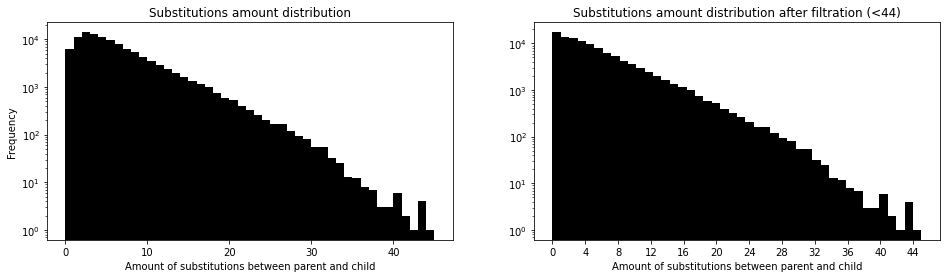

In [3]:
refseq = next(read_fasta_generator(REFSEQ_PATH))[1].replace('\n', '')
print(len(refseq))

with open(SUBSTITUTIONS_PATH) as fin:
    substitutions = json.load(fin)
# filtered_subst = [x for x in substitutions if len(x[-1]) < CUTOFF]
filtered_subst = substitutions

print(len(substitutions))
print(len(filtered_subst))

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title("Substitutions amount distribution")
plt.ylabel('Frequency')
plt.hist([len(x[-1]) for x in substitutions], bins=45, color='k')
plt.yscale("log")
plt.xlabel("Amount of substitutions between parent and child")

plt.subplot(122)
plt.title(f"Substitutions amount distribution after filtration (<{CUTOFF})")
plt.hist([len(x[-1]) for x in filtered_subst], bins=44, color='k')
plt.yscale("log")
plt.xlabel("Amount of substitutions between parent and child")
plt.xticks(range(0, CUTOFF + 4, 4))
plt.show()

In [7]:
# pd.DataFrame({'parent_child_diff': [len(x[-1]) for x in substitutions]}).to_csv('../data/parent_child_diff.csv')

In [4]:
refseq_len = len(refseq)
subs_by_pos = [[] for _ in range(refseq_len)]
n_overall_substitutions = 0
n_snps = 0

for parent_node, child_node, substs in filtered_subst:
    for pos, parent_nucl, child_nucl, _, _ in substs:
        subs_by_pos[pos].append((parent_nucl, child_nucl, ))  # parent_node, child_node
        n_overall_substitutions += 1
        if parent_nucl != '-' and child_nucl != '-':
            n_snps += 1
print(f'{n_overall_substitutions} substitutions in the dataset')
print(f"{n_snps} SNPs (not indel)")

631407 substitutions in the dataset
618118 SNPs (not indel)


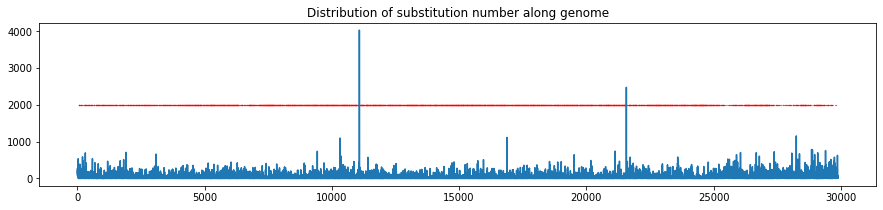

In [9]:
plt.figure(figsize=(15, 3))
plt.plot(range(len(subs_by_pos)), list(map(len, subs_by_pos)))

_x = []
for i, x in enumerate(list(map(len, subs_by_pos))):
    if x == 0:
        _x.append(i)

plt.title("Distribution of substitution number along genome")
plt.scatter(_x, np.zeros_like(_x) + 2000, s=.01, c='r');

## functions for secondary structure (ss) loading

In [10]:
def dict_from_pairs(pairs: list):
    """there is a list of pairs, that will be converted to
    dict, where each element of pair is key and value at the same time: 
    {k: v, v: k} for any (k, v) in pairs
    """
    d1 = {k: v for k, v in pairs}
    d2 = {v: k for k, v in pairs}
    d1.update(d2)
    return d1


def assign_ss_types(start, stop, paired_pos_dict):
    """ return the type of nucleotides in ss; 

    type variants:
    0: free
    1: stem 
    2: hairpin loop
    3: bulge loop or internal loop

    @param ss_idx, int - index of one secondary cluster from output of `read_ss_file` func
    @param nucl_idx, int - index of nucleotide in the ss
    """
    n = stop - start + 1
    inside_loop = False
    ss_types = [0] * n
    cur_loop_stop = -1

    for pos in range(n):
        if pos in paired_pos_dict:
            if not inside_loop:
                cur_loop_stop = paired_pos_dict[pos]
                inside_loop = True

            cur_ss_type = 1
            last_stem_pos = pos
        else:
            if inside_loop:
                next_stem_pos = pos + 1
                # here we find next stem pos
                while next_stem_pos not in paired_pos_dict:
                    next_stem_pos += 1

                if paired_pos_dict[last_stem_pos] == next_stem_pos:
                    cur_ss_type = 2
                else:
                    cur_ss_type = 3
            else:
                cur_ss_type = 0

        ss_types[pos] = cur_ss_type

        if pos == cur_loop_stop:
            inside_loop = False

    return ss_types


def read_ss_file(filepath, from_site=False):
    """read ss file in multiple fasta format and 
    return list of clusters, where there are: 
    - cluster header,
    - start_pos (0-based), 
    - stop_pos (0-based), 
    - ss_pairs of paired nucleotides (0-based) 
    - dict of pairs in both direction of pair (very usefull) 
    - ss sequence"""
    
    if "from_site" in filepath:
        from_site = True
        
    clusters = []
    with open(filepath) as fin:
        for line in fin:
            if line == "\n":
                break
            if line.startswith(">"):
                header = line.strip()
            else:
                ss_seq = line.strip()
                ss_pairs = parse_vienna_to_pairs(ss_seq)
                ss_pairs_0_based = [(x - 1, y - 1) for x, y in ss_pairs[0]]
                paired_pos_dict = dict_from_pairs(ss_pairs_0_based)
                start_pos, stop_pos = map(
                    int, header.lstrip(">consensus_").lstrip(">motif_").split("-"))
                if not from_site:
                    start_pos -= 1
                    stop_pos -= 1
                ss_types = assign_ss_types(start_pos, stop_pos, paired_pos_dict)
                clusters.append((
                    header,
                    start_pos,
                    stop_pos,
                    ss_pairs_0_based,
                    paired_pos_dict,
                    ss_types,
                    ss_seq,
                ))
    return clusters

In [11]:
# read ss-file
ss_clusters = read_ss_file(SEC_STRUCT_PATH_from_site)
print(ss_clusters[0])

('>motif_83-126', 83, 126, [(0, 43), (1, 42), (2, 41), (3, 40), (4, 39), (5, 38), (6, 37), (7, 36), (9, 34), (10, 33), (12, 32), (13, 31), (14, 30), (15, 29), (17, 27), (18, 26), (19, 25)], {0: 43, 1: 42, 2: 41, 3: 40, 4: 39, 5: 38, 6: 37, 7: 36, 9: 34, 10: 33, 12: 32, 13: 31, 14: 30, 15: 29, 17: 27, 18: 26, 19: 25, 43: 0, 42: 1, 41: 2, 40: 3, 39: 4, 38: 5, 37: 6, 36: 7, 34: 9, 33: 10, 32: 12, 31: 13, 30: 14, 29: 15, 27: 17, 26: 18, 25: 19}, [1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1], '((((((((.((.((((.(((.....))).)))))).))))))))')


In [12]:
# max len of ss-interval => two substitutions can't be 
max([len(x[-1]) for x in ss_clusters])

312

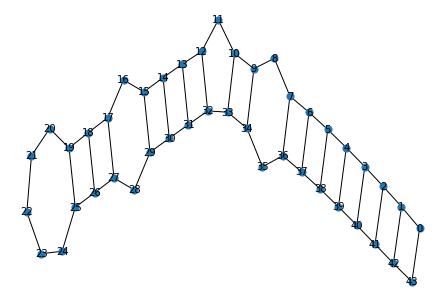

In [13]:
full_genome_pairs = defaultdict(lambda: None)  # 0-based

for ss in ss_clusters:
    start = ss[1]
    pairs = ss[4]
    for k, v in pairs.items():
        full_genome_pairs[k + start] = v + start

full_genome_pairs = dict(full_genome_pairs)


def ss_graph_constructor(ss_cluster):
    n = ss_cluster[2] - ss_cluster[1] + 1
    G = nx.path_graph(n)
    pairs = ss_cluster[3]
    for v1, v2 in pairs:
        G.add_edge(v1, v2)
    return G


def full_ss_graph_constructor():
    n = refseq_len
    G = nx.path_graph(n)
    for v1, v2 in full_genome_pairs.items():
        G.add_edge(v1, v2)
#     for ss_cluster in ss_clusters:
#         pairs = ss_cluster[3]
#         for v1, v2 in pairs:
#             G.add_edge(v1, v2)
    return G


ss_clusters_graphs = list(map(ss_graph_constructor, ss_clusters))
full_genome_graph = full_ss_graph_constructor()
nx.draw_kamada_kawai(ss_clusters_graphs[0], node_size=50,
                     with_labels=True, font_size=10)

In [14]:
sum([len(x[-1]) for x in ss_clusters]) / 29903

0.20335752265658963

In [15]:
full_genome_pairs[602]

584

### SS intervals positions on the genome

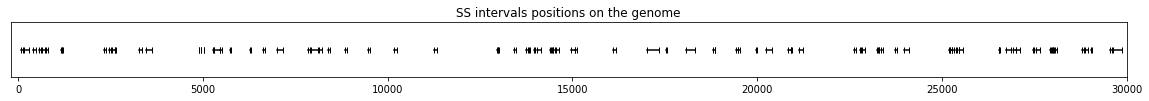

6081


In [16]:
total_ss_len = 0
plt.figure(figsize=(20, 1))
for data in ss_clusters:
    x1, x2 = data[1:3]
    total_ss_len += x2 - x1 + 1
    plt.plot([x1, x2], [2, 2], '-|k')
plt.xlim((-200, 30000))
plt.yticks([])
plt.title("SS intervals positions on the genome")
plt.show()
print(total_ss_len)

In [17]:
def print_ss_fasta_to_draw(ss_clusters, idx1, idx2=None):
    idx2 = idx2 or idx1 + 1
    for i in range(idx1, idx2):
        cl = ss_clusters[i]
        print(cl[0])
        print(refseq[cl[1]: cl[2] + 1])
        print(cl[-1])

In [18]:
print_ss_fasta_to_draw(ss_clusters, 4)

>motif_651-723
AGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCT
((((.......((((.((((.((.((((......(((((....))))).)))).)))))))))).....))))


## Count substitutions in secondary structure and not in it

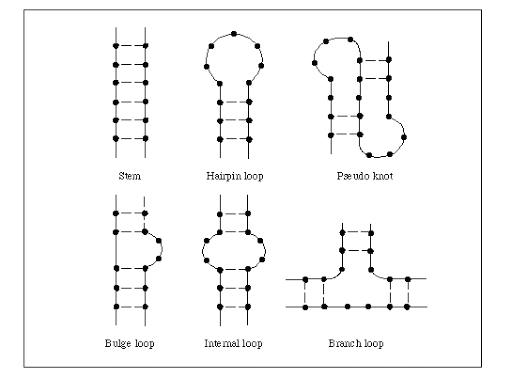

In [19]:
nsubs_per_pos = list(map(len, subs_by_pos))
sum(nsubs_per_pos)

631407

In [20]:
nsubs_per_cluster = [defaultdict(list) for _ in range(len(ss_clusters))]
nsubs_per_cluster_df = []

for ss_idx, data in enumerate(ss_clusters):
    xmin, xmax = data[1:3]  # both included
    ss_types = data[5]
    for pos in range(xmin, xmax + 1):
        ss_nucl_idx = pos - xmin
        cur_nsubs = nsubs_per_pos[pos]
        cur_ss_type = ss_types[ss_nucl_idx]
        nsubs_per_cluster[ss_idx][cur_ss_type].append(cur_nsubs)
        nsubs_per_cluster_df.append((ss_idx, cur_ss_type, cur_nsubs))

nsubs_per_cluster_df = pd.DataFrame(nsubs_per_cluster_df, columns=["ss_idx", "cur_ss_type", "cur_nsubs"])

In [21]:
nsubs_per_cluster_matrix = np.full((len(nsubs_per_cluster), 4), np.nan)
for cl_idx, cl_dct in enumerate(nsubs_per_cluster):
    for ss_type, v in cl_dct.items():
        nsubs_per_cluster_matrix[cl_idx, ss_type] = np.mean(v)

In [22]:
# plt.figure(figsize=(20, 2))
# sns.heatmap(nsubs_per_cluster_matrix.T)
# plt.xlabel("ss cluster idx")
# plt.ylabel("ss type")
# plt.title("means of substitution counts per ss cluster idx and per ss type")

In [23]:
nsubs_per_cluster_df['is_stem'] = (nsubs_per_cluster_df.cur_ss_type == 1).astype(int)
print(nsubs_per_cluster_df[nsubs_per_cluster_df.is_stem == 1].shape)
nsubs_per_cluster_df.head()

(4222, 4)


,ss_idx,cur_ss_type,cur_nsubs,is_stem
0,0,1,20,1
1,0,1,4,1
2,0,1,0,1
3,0,1,7,1
4,0,1,15,1


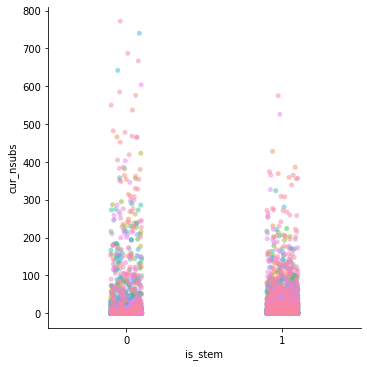

In [24]:
# https://seaborn.pydata.org/generated/seaborn.catplot.html#seaborn.catplot

sns.catplot(data=nsubs_per_cluster_df, x="is_stem", y="cur_nsubs", hue='ss_idx', 
            legend=False, alpha=.5)
plt.show()

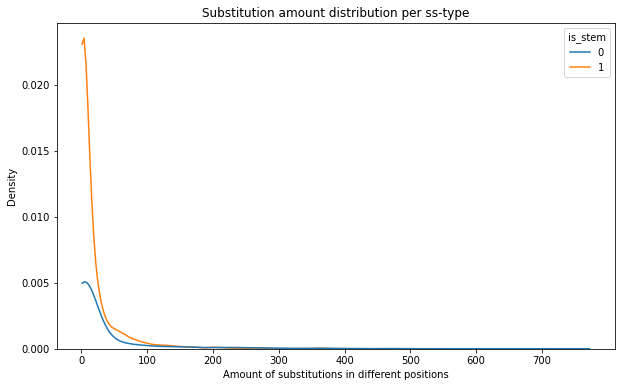

In [25]:
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html

plt.figure(figsize=(10, 6))
sns.kdeplot(data=nsubs_per_cluster_df, hue="is_stem", x="cur_nsubs", 
            clip=[1, nsubs_per_cluster_df.cur_nsubs.max()],
            common_norm=True, bw_adjust=1)
plt.title("Substitution amount distribution per ss-type")
plt.xlabel("Amount of substitutions in different positions")
plt.xticks(range(0, nsubs_per_cluster_df.cur_nsubs.max(), 100))
plt.show()

In [26]:
# plt.hist(nsubs_per_cluster_df[nsubs_per_cluster_df.ss_idx == 1].cur_nsubs, bins=100);

## Проверка того, сколько замещений внутри спаренных оснований

In [27]:
sum([len(x) for x in subs_by_pos])

631407

In [28]:
nsub_of_paired_collection = []
for i in full_genome_pairs:
    cur_nsub = len(subs_by_pos[i])
    nsub_of_paired_collection.append(cur_nsub)

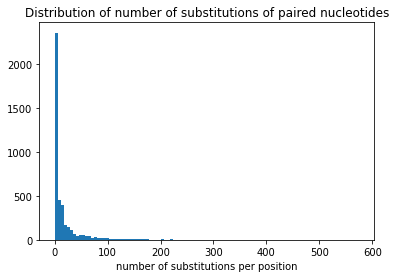

In [29]:
# sns.kdeplot(nsub_of_paired_collection, clip=[1.5, 700])
plt.hist(nsub_of_paired_collection, bins=100)
plt.title("Distribution of number of substitutions of paired nucleotides")
plt.xlabel("number of substitutions per position")
plt.show()

### Функции для подсчета расстояний. 
Ближайшая замены по первичной и по вторичной это разные позиции

In [30]:
def primary_distance(pos1, pos2):
    """@param pos1, pos2: int[0..29902], positions of genome using to calculate"""
    return abs(pos1 - pos2)


def secondary_distance(pos1, pos2):
    """calculate distance using secondary structure

    @param pos1, pos2: int[0..29902], positions of genome using to calculate
    distance between them

    distance calculated by dijkstra_path_length in genome graph
    """
    dist = nx.dijkstra_path_length(full_genome_graph, pos1, pos2)
    return dist


def distance2closest_substitution(i, substs, history=None):
    """ посчитает расстояние до ближайшей замены, если дать
    на вход индекс интересующей позиции (i) в общем скопе 
    замен (substs)

    return (distance1, distance2)
    """
    MAX_PRIMARY_DISTANCE = 1000
    n_substs = len(substs)
    assert 0 <= i < n_substs, 'substs intex out of range'

    if n_substs == 1:
        return None, None

    cur_pos = substs[i][0]    
    around_window = 5
    closest_subst_dist1 = closest_subst_dist2 = 30_000  # max
    clidex_by_primary = clidex_by_secondary = -1
    for j in range(max(i - around_window, 0), min(i + around_window, n_substs - 1) + 1):
        if i == j:
            continue
        maybe_cl_pos = substs[j][0]
        
        if history is not None:
            _pair_pos = (cur_pos, maybe_cl_pos)
            if _pair_pos in history:
                key = _pair_pos
            elif _pair_pos[::-1] in history:
                key = _pair_pos[::-1]
            else:
                key = None
        else:
            key = None
            
        if key is not None:
            cur_d1, cur_d2 = history[key]
        else:
            cur_d1 = primary_distance(cur_pos, maybe_cl_pos)
            if cur_d1 > MAX_PRIMARY_DISTANCE:
                continue
            cur_d2 = secondary_distance(cur_pos, maybe_cl_pos)
            history[(cur_pos, maybe_cl_pos)] = (cur_d1, cur_d2)
            history[(maybe_cl_pos, cur_pos)] = (cur_d1, cur_d2)
            
        if cur_d1 > MAX_PRIMARY_DISTANCE:
            continue
        if cur_d1 < closest_subst_dist1:
            # closest substitution index by primary structure
            clidex_by_primary = j
            closest_subst_dist1 = cur_d1
                
        if cur_d2 < closest_subst_dist2:
            # closest substitution index by secondary structure
            clidex_by_secondary = j
            closest_subst_dist2 = cur_d2

    return closest_subst_dist1, closest_subst_dist2

In [31]:
def is_paired(nucl1, nucl2):
    """check if given nucleotides can form Watson-Crick pairing"""
    nset = {nucl1, nucl2}
    if nset == {'A', 'T'} or nset == {'C', 'G'}:
        return True
    return False


def determine_substitution_type(subst: tuple, parent_node, child_node):
    """ looking at secondary structure and return type of subst:
    {complementary, not_complementary, not_in_sh}
    
    @param subst: tuple(pos, parent_nucl, child_nucl)
    to adress `ss_clusters`
    
    return stype (int): substitution type, one of:
    {
    0: комплементарные замены, приводящие к формированию комплементарных взаимодействий
    1: некомплементарные замены, разрушающие уже имеющиеся комплементарные взаимодействия
    2: замены, которые не восстанавливают комп. взаимодействия, хотя в референсе взаимодействие было
    3: вне вторичных взаимодействий
    4: еще есть комплементарные, которые заново сформированы за 1 итерацию
    }
    """
    pos, parent_nucl, child_nucl, _, _ = subst

    if pos in full_genome_pairs:
        # данный код выполняется, если
        # замутировала та, что находится в спаренном состоянии в рефсеке
        # нужно проверить ее тип, разрушила она парную связь иль нет
        the_pair_pos = full_genome_pairs[pos]
        
        parent_seq = get_sequence(parent_node)
        child_seq = get_sequence(child_node)
        
        parent_nucl_of_paired = parent_seq[the_pair_pos]
        child_nucl_of_paired = child_seq[the_pair_pos]
        
        # check if parent pair was existed
        if is_paired(parent_nucl, parent_nucl_of_paired):
            if not is_paired(child_nucl, child_nucl_of_paired):
                stype = 1  # parent yes, child no
            else:
                # здесь присходит парная замена с сохранением вторичной связи
#                 print('DIN-DON!', file=sys.stderr)
                stype = 4 # самый редкий, должно быть
        else:
            # родительские нуклы не были спарены, спарены ли детские?
            if is_paired(child_nucl, child_nucl_of_paired):
                stype = 0  # parent no, child yes
            else:
                stype = 2  # parent no, child no
    else:
        stype = 3
    
    return stype

### Запускать уже не нужно

In [32]:
final_fantasy = []
history = dict()

pair_idx = 0
for parent_node, child_node, substs in tqdm.tqdm(filtered_subst):
    substs = [x for x in substs if x[1] != '-' and x[2] != '-']

    if len(substs) < 2:
        # the pair parent-child dropped,
        # because we need calculate closest subst. for analysis
        pair_idx += 1
        continue
    
    for j in range(len(substs)):
        cur_subst = substs[j]
        cur_subst_type = determine_substitution_type(
            cur_subst, parent_node, child_node,
        )
        # calculate distance to closest subst. by secondary and primary structure
        nearest_subst_dist1, nearest_subst_dist2 = distance2closest_substitution(j, 
                                                                                 substs, 
                                                                                 history)
        
        final_fantasy.append((
            pair_idx,
            cur_subst[0],
            cur_subst[1],
            cur_subst[2],
            cur_subst_type,
            nearest_subst_dist1,
            nearest_subst_dist2,
#             len(substs),
            parent_node, 
            child_node,
        ))
    pair_idx += 1

100%|██████████| 109134/109134 [02:31<00:00, 720.20it/s] 


In [33]:
len(final_fantasy)

606936

In [34]:
sum([len(x[2]) for x in filtered_subst if len(x[2]) > 1])

620371

In [35]:
cols = ["pair_idx", 'pos', "parent_nucl", "child_nucl", 
        'stype', 'primary_dist2nearest', 'secondary_dist2nearest', 
        'parent_node', 'child_node',]
cur_time = time.asctime().replace(" ", "_")

df = pd.DataFrame(final_fantasy, columns=cols)
final_path = f"../data/new_final_fantasy_{cur_time}.csv"
df.to_csv(final_path, index=None)
df.head()

,pair_idx,pos,parent_nucl,child_nucl,stype,primary_dist2nearest,secondary_dist2nearest,parent_node,child_node
0,0,240,C,T,3,30000,30000,#54567#,#51858#
1,0,9168,C,T,3,30000,30000,#54567#,#51858#
2,0,10318,T,C,3,854,854,#54567#,#51858#
3,0,11172,A,C,3,854,854,#54567#,#51858#
4,0,12622,T,C,3,30000,30000,#54567#,#51858#


In [36]:
# last path
final_path

'../data/new_final_fantasy_Wed_Apr__7_01:16:16_2021.csv'

In [5]:
df = pd.read_csv("../data/new_final_fantasy_Sat_May__8_13:54:58_2021.csv")
df.head()

,pair_idx,pos,parent_nucl,child_nucl,stype,primary_dist2nearest,secondary_dist2nearest,parent_node,child_node
0,0,240,C,T,0,30000,30000,#54567#,#51858#
1,0,9168,C,T,0,30000,30000,#54567#,#51858#
2,0,10318,T,C,0,854,854,#54567#,#51858#
3,0,11172,A,C,0,854,854,#54567#,#51858#
4,0,12622,T,C,0,30000,30000,#54567#,#51858#


In [6]:
assert df[df.primary_dist2nearest <= 1000].shape == \
       df[df.primary_dist2nearest != 30_000].shape

In [7]:
df = df[df.primary_dist2nearest <= 1000 ]
df.shape

(264235, 9)

In [9]:
df

,pair_idx,pos,parent_nucl,child_nucl,stype,primary_dist2nearest,secondary_dist2nearest,parent_node,child_node
2,0,10318,T,C,0,854,854,#54567#,#51858#
3,0,11172,A,C,0,854,854,#54567#,#51858#
8,0,27963,T,C,0,508,406,#54567#,#51858#
9,0,28471,T,C,0,203,203,#54567#,#51858#
10,0,28674,A,G,0,194,131,#54567#,#51858#
...,...,...,...,...,...,...,...,...,...
606931,109133,28471,C,T,0,397,334,#8300#,hCoV-19/USA/TX-HMH-MCoV-11229/2020|EPI_ISL_789...
606932,109133,28868,C,T,8,12,12,#8300#,hCoV-19/USA/TX-HMH-MCoV-11229/2020|EPI_ISL_789...
606933,109133,28880,A,G,3,1,1,#8300#,hCoV-19/USA/TX-HMH-MCoV-11229/2020|EPI_ISL_789...
606934,109133,28881,A,G,3,1,1,#8300#,hCoV-19/USA/TX-HMH-MCoV-11229/2020|EPI_ISL_789...


In [39]:
df.stype.value_counts(sort=False).reset_index()

,index,stype
0,0,15065
1,1,15685
2,2,1965
3,3,231510
4,4,10


In [40]:
# https://seaborn.pydata.org/tutorial/color_palettes.html
palette = sns.color_palette("hls", 5)
palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86)]

Text(0.5, 1.0, 'Кол-во замен под заданным типом')

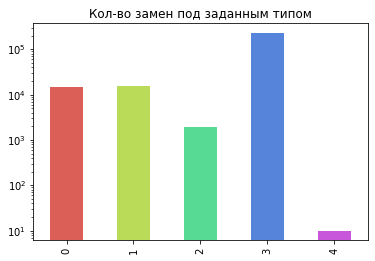

In [41]:
df.stype.value_counts(sort=False).plot.bar(color=palette);
plt.yscale("log")
plt.title("Кол-во замен под заданным типом")

In [42]:
# sns.kdeplot(hue="stype", x="primary_dist2nearest", data=df[df.stype != 4], palette="Spectral", 
#             clip=[2, df.primary_dist2nearest.max()], multiple="stack", common_norm=True)

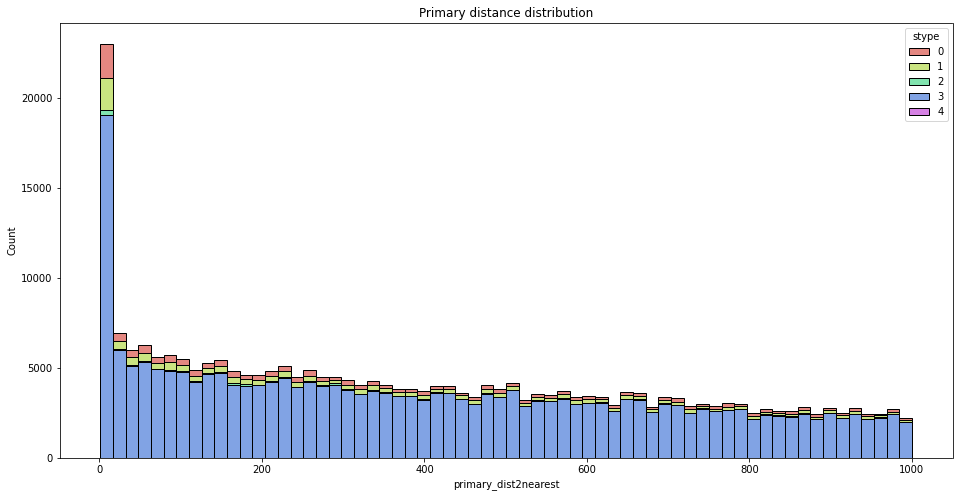

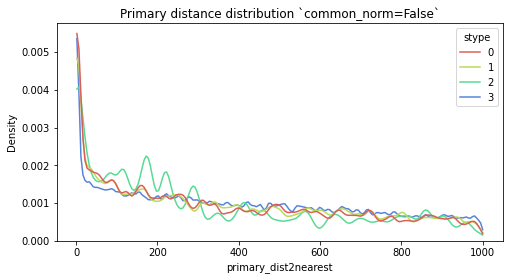

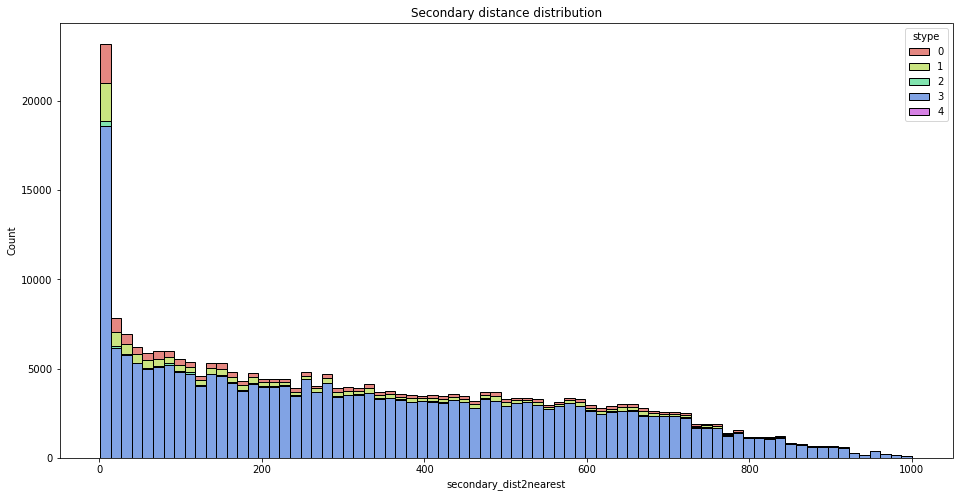

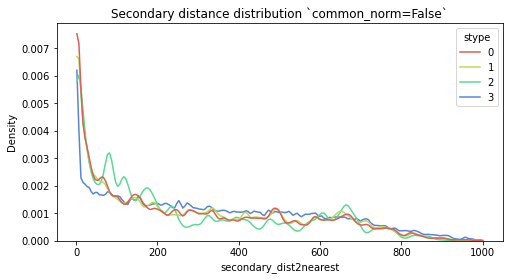

In [43]:
plt.figure(figsize=(16, 8))
# sns.kdeplot(hue="stype", x="primary_dist2nearest", data=df[df.stype != 4], palette="Spectral", 
#             clip=[2, df.primary_dist2nearest.max()], multiple="stack", common_norm=True)
sns.histplot(hue="stype", x="primary_dist2nearest", data=df, 
             palette=palette, multiple="stack", )

plt.title('Primary distance distribution')
plt.show()

plt.figure(figsize=(8, 4))
sns.kdeplot(hue="stype", x="primary_dist2nearest", data=df[df.stype != 4], palette=palette[:4], 
            clip=[2, df.primary_dist2nearest.max()], common_norm=False, bw_adjust=.2)

plt.title('Primary distance distribution `common_norm=False`')
plt.show()


plt.figure(figsize=(16, 8))
# sns.kdeplot(hue="stype", x="secondary_dist2nearest", data=df[df.stype != 4], palette="Spectral", 
#             clip=[2, df.secondary_dist2nearest.max()], multiple="stack", common_norm=True)
sns.histplot(hue="stype", x="secondary_dist2nearest", data=df, 
             palette=palette, multiple="stack", )

plt.title('Secondary distance distribution')
plt.show()

plt.figure(figsize=(8, 4))
sns.kdeplot(hue="stype", x="secondary_dist2nearest", data=df[df.stype != 4], palette=palette[:4], 
            clip=[2, df.secondary_dist2nearest.max()], common_norm=False, bw_adjust=.2)

plt.title('Secondary distance distribution `common_norm=False`')
plt.show()

In [44]:
df[df.stype == 4].primary_dist2nearest.value_counts()

96    10
Name: primary_dist2nearest, dtype: int64

In [45]:
df[df.stype == 4].secondary_dist2nearest.value_counts()

1    10
Name: secondary_dist2nearest, dtype: int64

In [46]:
n = df.stype.nunique()
print("MannwhitneyuResult for Primary")
for i in range(n):
    for j in range(i + 1, n):            
        x = df[df.stype == i].primary_dist2nearest
        y = df[df.stype == j].primary_dist2nearest
        res = mannwhitneyu(x, y)
        verdict = "ok" if res.pvalue < .001 else 'not ok'
        print(f"{i} and {j} : p-value = {res.pvalue:.1e} - {verdict}")

MannwhitneyuResult for Primary
0 and 1 : p-value = 6.3e-05 - ok
0 and 2 : p-value = 3.3e-04 - ok
0 and 3 : p-value = 2.0e-83 - ok
0 and 4 : p-value = 4.9e-03 - not ok
1 and 2 : p-value = 7.4e-08 - ok
1 and 3 : p-value = 2.7e-47 - ok
1 and 4 : p-value = 3.0e-03 - not ok
2 and 3 : p-value = 1.4e-28 - ok
2 and 4 : p-value = 5.8e-03 - not ok
3 and 4 : p-value = 4.5e-04 - ok


In [47]:
n = df.stype.nunique()
print("MannwhitneyuResult for Secondary")
for i in range(n):
    for j in range(i + 1, n):            
        x = df[df.stype == i].secondary_dist2nearest
        y = df[df.stype == j].secondary_dist2nearest
        res = mannwhitneyu(x, y)
        verdict = "ok" if res.pvalue < .001 else 'not ok'
        print(f"{i} and {j} : p-value = {res.pvalue:.1e} - {verdict}")

MannwhitneyuResult for Secondary
0 and 1 : p-value = 2.7e-05 - ok
0 and 2 : p-value = 1.8e-03 - not ok
0 and 3 : p-value = 1.7e-206 - ok
0 and 4 : p-value = 1.6e-07 - ok
1 and 2 : p-value = 5.6e-07 - ok
1 and 3 : p-value = 3.1e-146 - ok
1 and 4 : p-value = 1.1e-07 - ok
2 and 3 : p-value = 1.6e-50 - ok
2 and 4 : p-value = 2.5e-07 - ok
3 and 4 : p-value = 7.8e-08 - ok
